# Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import re

In [2]:
%matplotlib inline

Data will be processed and output as a new csv.

In [3]:
feature_names = [
    "clumpThickness",
    "uniformityOfCellSize",
    "uniformityOfCellShape",
    "marginalAdhesion",
    "singleEpithelialCellSize",
    "bareNuclei",
    "blandChromatin",
    "normalNucleoli",
    "mitoses",
    "class"
]

data = pd.read_csv(
    "../data/dataset.csv",
    names=feature_names,
    na_values=["?"]
)

data.head()

,clumpThickness,uniformityOfCellSize,uniformityOfCellShape,marginalAdhesion,singleEpithelialCellSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,class
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


## Preprocessing steps

1. Data exploration
    - [x] Binarize target variable
    - [x] Missing values
        - [ ] Replace by suitable estimate or
        - [x] Discard
    - [x] [Visualise the ratio of classes](#Visualise-the-ratio-of-classes)
    - [x] Look at each feature
        - Box plot
        - Outliers
2. Normalization
    - Might not be possible - look into
3. Correlation matrix
    - Analyse the correlation between features and target; features and features
4. Feature selection
    - Weakly correlated features can be discarded
    - Duplicated features can be discarded
    - PCA, RCA, ICA in a separate script

# 1. Data exploration

## Binarize the target variable

The dataset is labelled as 2 indicating a benign tumour, and 4 indicating a malignant one. Firstly we will binarize this target label into 0 for benign and 1 for malignant.

In [4]:
data["class"] = (data["class"] > 2).astype('int')

## Consider missing values

Next we can look for missing values in our data. The missing values in the data are labelled with `?`, which is passed to the csv reader to parse as `NaN`. When `NaN` is present in a column of `int64` the dtype is cast to float, so columns with `NaN` values will be of type `float64`.

In [5]:
data.dtypes

clumpThickness                int64
uniformityOfCellSize          int64
uniformityOfCellShape         int64
marginalAdhesion              int64
singleEpithelialCellSize      int64
bareNuclei                  float64
blandChromatin                int64
normalNucleoli                int64
mitoses                       int64
class                         int64
dtype: object

The `bareNuclei` column has been casted to `float64`, meaning there are some missing values in this column.

In [6]:
print(f'Values missing in bareNuclei? {any(data["bareNuclei"].isna())}') # Some values are NaN
np.count_nonzero(data.isna())

Values missing in bareNuclei? True


16

There are 16 instances of missing values. Rows containing them can now be removed.

In [7]:
data.dropna(axis='index', how='any', inplace=True)
data

,clumpThickness,uniformityOfCellSize,uniformityOfCellShape,marginalAdhesion,singleEpithelialCellSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,class
1000025,5,1,1,1,2,1.0,3,1,1,0
1002945,5,4,4,5,7,10.0,3,2,1,0
1015425,3,1,1,1,2,2.0,3,1,1,0
1016277,6,8,8,1,3,4.0,3,7,1,0
1017023,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2.0,1,1,1,0
841769,2,1,1,1,2,1.0,1,1,1,0
888820,5,10,10,3,7,3.0,8,10,2,1
897471,4,8,6,4,3,4.0,10,6,1,1


## Visualise the ratio of classes

The proportion of positive to negative class (malignant to benign cases) can be visualised using a historgram. Note since the target is now binarized the values will only be 0 or 1.

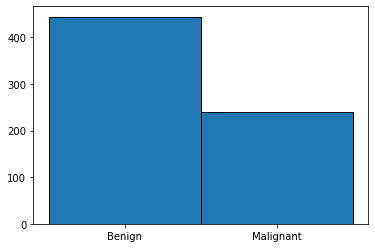

In [37]:
bin_vals, _, _ = plt.hist(data["class"], [-0.5, 0.5, 1.5], ec="k")
plt.xticks((0, 1), ("Benign", "Malignant"))
plt.show()

In [36]:
n_benign = bin_vals[0]
n_malig = bin_vals[1]

ratio = n_benign / (n_benign + n_malig) * 100
print(f"The dataset is comprised of {ratio:.2f}% beingn examples and {100-ratio:.2f}% malignant examples.")

The dataset is comprised of 65.01% beingn examples and 34.99% malignant examples.


There is an inbalance in the data; approximately 2/3 of the data are the negative class (benign). However it is not too bad/significant.

## Visualising the features

In [45]:
def draw_histogram(feature_index):
    title = re.sub('([A-Z]+)', r' \1', data.columns[feature_index]).lower()

    figure, (his, box) = plt.subplots(1, 2, figsize=(15, 8))
    figure.suptitle(f'Histogram and boxplot for {title}')
    
    # Plot a histogram with a nice title and labels
    his.hist(data.iloc[:, feature_index], ec="k")
    his.set_xlabel(data.columns[feature_index])
    his.set_ylabel("Count")

    box.boxplot(data.iloc[:, feature_index], notch=True)
    box.set_yticks(range(11))

In [47]:
widgets.interact(draw_histogram, feature_index=widgets.IntSlider(min=0, max=8))

interactive(children=(IntSlider(value=0, description='feature_index', max=8), Output()), _dom_classes=('widget…

<function __main__.draw_histogram(feature_index)>

In [42]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,clumpThickness,uniformityOfCellSize,uniformityOfCellShape,marginalAdhesion,singleEpithelialCellSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,class
clumpThickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957,0.714790
uniformityOfCellSize,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755,0.820801
uniformityOfCellShape,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258,0.821891
marginalAdhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898,0.706294
singleEpithelialCellSize,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583,0.690958
bareNuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210,0.822696
blandChromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011,0.758228
normalNucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757,0.718677
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000,0.423448
class,0.714790,0.820801,0.821891,0.706294,0.690958,0.822696,0.758228,0.718677,0.423448,1.000000
